In [1]:
import numpy as np
import matplotlib.pyplot as plt
import paths
import os
from scipy.ndimage import zoom
from scipy.interpolate import griddata

from dime import DopplerImaging, load_data_from_pickle, make_fakemap, simulate_data
from config import load_config

/Users/xqchen/workspace/igrins_doppler_imaging/.snakemake/conda/aeb890ed28d84060e5333cb74aa86281_/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
instru = "CRIRES"
target = "W1049B"
band = "K"
params_starry, params_run, goodchips, modelspec = load_config(instru, target, band, sim=True)
model_datafile = paths.data / f"fitted/{instru}_{target}_{band}_{modelspec}.pickle"
savedir = f"sim_1049b_L"
if not os.path.exists(paths.figures / savedir):
    os.makedirs(paths.figures / savedir)

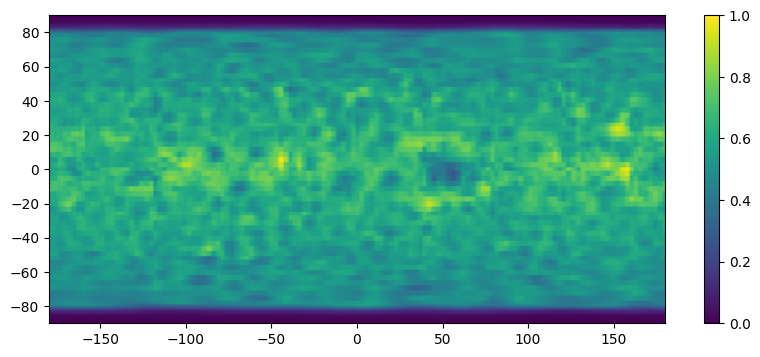

In [4]:
nlat, nlon = 180, 360
fakemap = np.ones((nlat, nlon))
x, y = np.meshgrid(np.linspace(-nlon/2, nlon/2 - 1, nlon), 
                    np.linspace(-nlat/2, nlat/2 - 1, nlat))
img = np.loadtxt(paths.data/'modelmaps/1049b_L.txt')
plt.figure(figsize=(10, 4))
plt.imshow(img, extent=(-180, 180, -90, 90), cmap='viridis', vmin=0, vmax=1)
plt.colorbar()

In [5]:
def fill_nan_2d(array, method='linear'):
    # Create grid coordinates
    rows, cols = array.shape
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    
    # Get valid (non-NaN) points and values
    mask = ~np.isnan(array)
    points = np.c_[x[mask].ravel(), y[mask].ravel()]
    values = array[mask].ravel()
    
    # Get all grid points (including NaNs)
    all_points = np.c_[x.ravel(), y.ravel()]
    
    # Interpolate to fill NaNs
    filled_values = griddata(points, values, all_points, method=method, fill_value=np.nanmean(values))
    
    # Reshape to original 2D shape
    filled_array = filled_values.reshape(rows, cols)
    
    return filled_array

Flux scaled to requested contrast = 35%.
Spot aligned at lon=0.


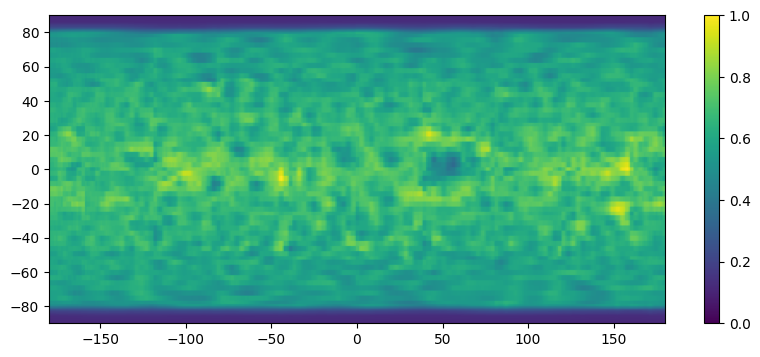

In [6]:
# make fakemap
contrast = 0.35  # spot contrast
lon_deg = 0  # spot longitude
amp = 1. - contrast
img /= np.max(img)
diff = 1. - img
diffnew = diff * amp / np.max(diff[80:100])
fakemap = 1. - diffnew
fakemap[fakemap < 0] = 0
fakemap = np.roll(fakemap[::-1], shift=int(lon_deg), axis=1)

#fakemap = img
print(f"Flux scaled to requested contrast = {contrast*100:.0f}%.")
print(f"Spot aligned at lon={lon_deg}.")
plt.figure(figsize=(10, 4))
plt.imshow(fakemap, extent=(-180, 180, -90, 90), cmap='viridis', vmin=0, vmax=1)
plt.colorbar()

### Simulation

Data loaded from file /Users/xqchen/workspace/doppler-imaging-maxentropy/data/fitted/CRIRES_W1049B_K_t1500g1000f8.pickle.
observed: (14, 4, 824)
template: (14, 4, 824)
wav: (4, 824)
Median flux error per pixel = 0.020


Pre-computing some matrices... Done.
Compiling `P`... Done.
Compiling `set_vector`... Done.
Compiling `enforce_shape`... Done.
Compiling `get_flux_from_dotconv`... Done.
Pre-computing some matrices... Done.
Compiling `P`... Done.
Compiling `set_vector`... Done.
Compiling `enforce_shape`... Done.
Compiling `get_flux_from_dotconv`... Done.
Pre-computing some matrices... Done.
Compiling `P`... Done.
Compiling `set_vector`... Done.
Compiling `enforce_shape`... Done.
Compiling `get_flux_from_dotconv`... Done.
Pre-computing some matrices... Done.
Compiling `P`... Done.
Compiling `set_vector`... Done.
Compiling `enforce_shape`... Done.
Compiling `get_flux_from_dotconv`... Done.
Pre-computing some matrices... Done.
Compiling `P`... Done.
Compiling `set_vector`... Done.
Compiling `render`... Done.


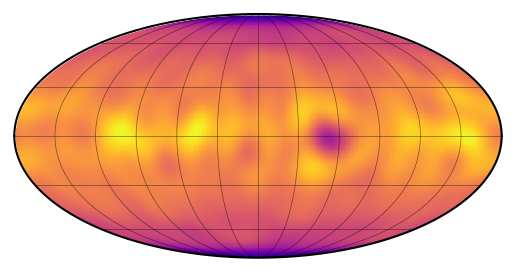

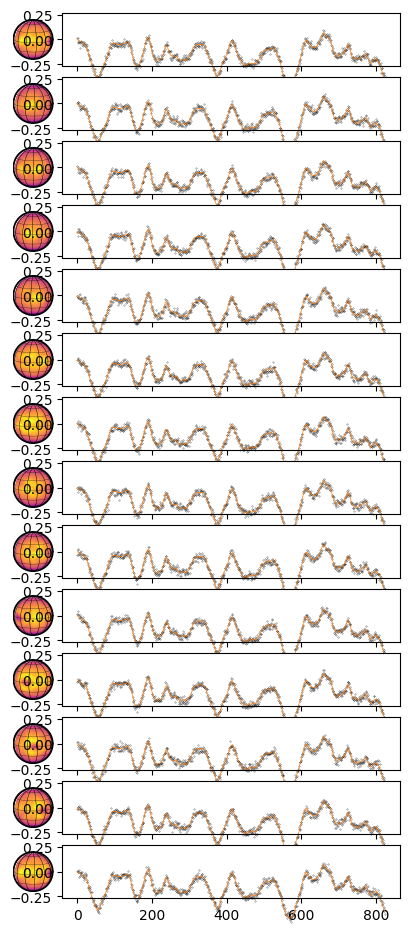

In [7]:
# Load data from fit pickle
wav_nm, template, _, error = load_data_from_pickle(model_datafile, goodchips, instru="CRIRES")
flux_err = eval(f'{np.nanmedian(error):.3f}')
flux_err = 0.02  # manually set flux error
print(f"Median flux error per pixel = {flux_err:.3f}")
mean_spectrum = np.median(template, axis=0)
observed = simulate_data(fakemap, mean_spectrum, wav_nm, flux_err, params_starry, 
                        plot_ts=True, custom_plot=False,
                        savedir=paths.figures/f"{savedir}/fakemap.png")

nobs: 14, nchip: 4, npix: 824
Created equa-area grid of 216 cells, in 12 latitude grids with [ 6 12 17 21 25 27 27 25 21 17 12  6] lontitude cells.
chip 0
chip 1
chip 2
chip 3
metric: -10623.60, chisq: 250.33, entropy: 5.37


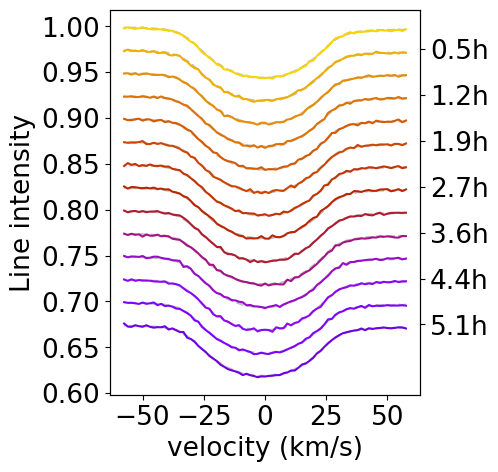

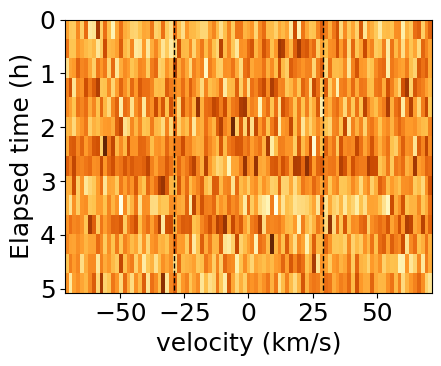

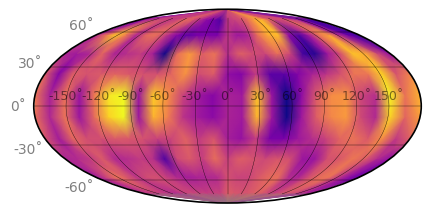

In [192]:
map_sim = DopplerImaging(wav_nm, goodchips, params_run, instru="CRIRES")
map_sim.load_data(observed, template, error)
map_sim.make_lsd_profile(modelspec, plot_lsd_profiles=True, plot_deviation_map=True, savedir=paths.figures/f"{savedir}")
map_sim.solve(create_obs_from_diff=True, solver='scipy')
map_sim.plot_mollweide_map(vmin=90, vmax=110, savedir=paths.figures/f"{savedir}/solver1.png")

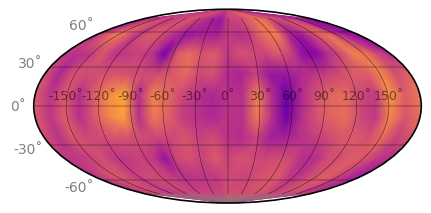

In [193]:
map_sim.plot_mollweide_map(vmin=80, vmax=120, savedir=paths.figures/f"{savedir}/solver1.png")

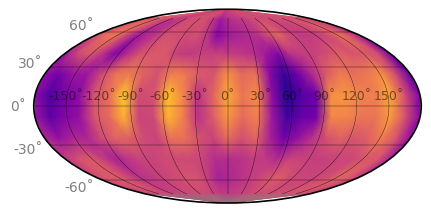

In [108]:
map_sim.plot_mollweide_map(vmin=75, vmax=125, savedir=paths.figures/f"{savedir}/solver1.png")

In [194]:
# save bestparamgrid
np.savetxt(paths.figures/f"{savedir}/bestparamgrid.txt", map_sim.bestparamgrid, fmt='%.4f', delimiter=' ')